In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings

Mounted at /content/drive
/content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings


In [4]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 45.3 MB/s eta 0:00:00


# LSTM Model with Word2Vec Skip-gram Embeddings
## Drug Reviews Classification - Gershom

**Model**: LSTM (Long Short-Term Memory) / BiLSTM
**Embedding**: Word2Vec Skip-gram (200-dim, medium config)
**Task**: Drug review rating prediction

---

### Notebook Structure:
1. Setup and Data Loading
2. Word2Vec Embedding Training
3. LSTM Model Architecture
4. Training & Evaluation
5. Results Analysis

## 1. Setup and Imports

In [5]:
# Standard libraries
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Dense, Dropout, Embedding,
    Input, GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Shared modules
from src.data_utils import DataLoader, create_dataset_from_dataframe
from src.preprocessing_pipeline import get_preprocessor, TextPreprocessor
from embeddings.word2vec_embedding import Word2VecEmbedding, get_word2vec_embedding

print(" All imports successful!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

 All imports successful!
TensorFlow version: 2.19.0
GPU Available: []


## 2. Configuration

In [6]:
# Paths
TRAIN_PATH = '/content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings/data/drug_review_train.csv'
VAL_PATH = '/content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings/data/drug_review_validation.csv'
TEST_PATH = '/content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings/data/drug_review_test.csv'

# Data columns
TEXT_COLUMN = 'review'
LABEL_COLUMN = 'rating'

# Preprocessing (MINIMAL FOR SPEED)
PREPROCESSING_CONFIG = 'minimal'  # ⚠️ CHANGED: minimal preprocessing = faster!

# Embedding configuration
EMBEDDING_TYPE = 'word2vec'
EMBEDDING_CONFIG = 'skipgram_medium'  # 200-dim, 10 epochs
EMBEDDING_DIM = 200

# Model architecture (EXTREMELY OPTIMIZED FOR SPEED)
USE_BIDIRECTIONAL = False
LSTM_UNITS = 32  #
DROPOUT_RATE = 0.3
RECURRENT_DROPOUT = 0.2
DENSE_UNITS = 64

# Training (EXTREMELY OPTIMIZED FOR SPEED)
BATCH_SIZE = 256
EPOCHS = 15
LEARNING_RATE = 0.001
PATIENCE = 3

# Sequence parameters (EXTREMELY OPTIMIZED FOR SPEED)
MAX_SEQUENCE_LENGTH = 75
VOCAB_SIZE = 5000

## 3. Load and Preprocess Data

In [7]:
# Load datasets
print("Loading datasets...")
train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
print(f"\nColumns: {list(train_df.columns)}")
print(f"\nClass distribution (train):")
print(train_df[LABEL_COLUMN].value_counts().sort_index())

Loading datasets...
Train size: 110811
Validation size: 27703
Test size: 46108

Columns: ['Unnamed: 0', 'patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length']

Class distribution (train):
rating
1.0     14286
2.0      4776
3.0      4540
4.0      3501
5.0      5711
6.0      4359
7.0      6671
8.0     13305
9.0     19407
10.0    34255
Name: count, dtype: int64


Total words (with repetition): 10,510,349
Unique words (vocabulary size): 41,922
Average word frequency: 250.71

Words needed for 80% coverage: 445
Words needed for 90% coverage: 1,244


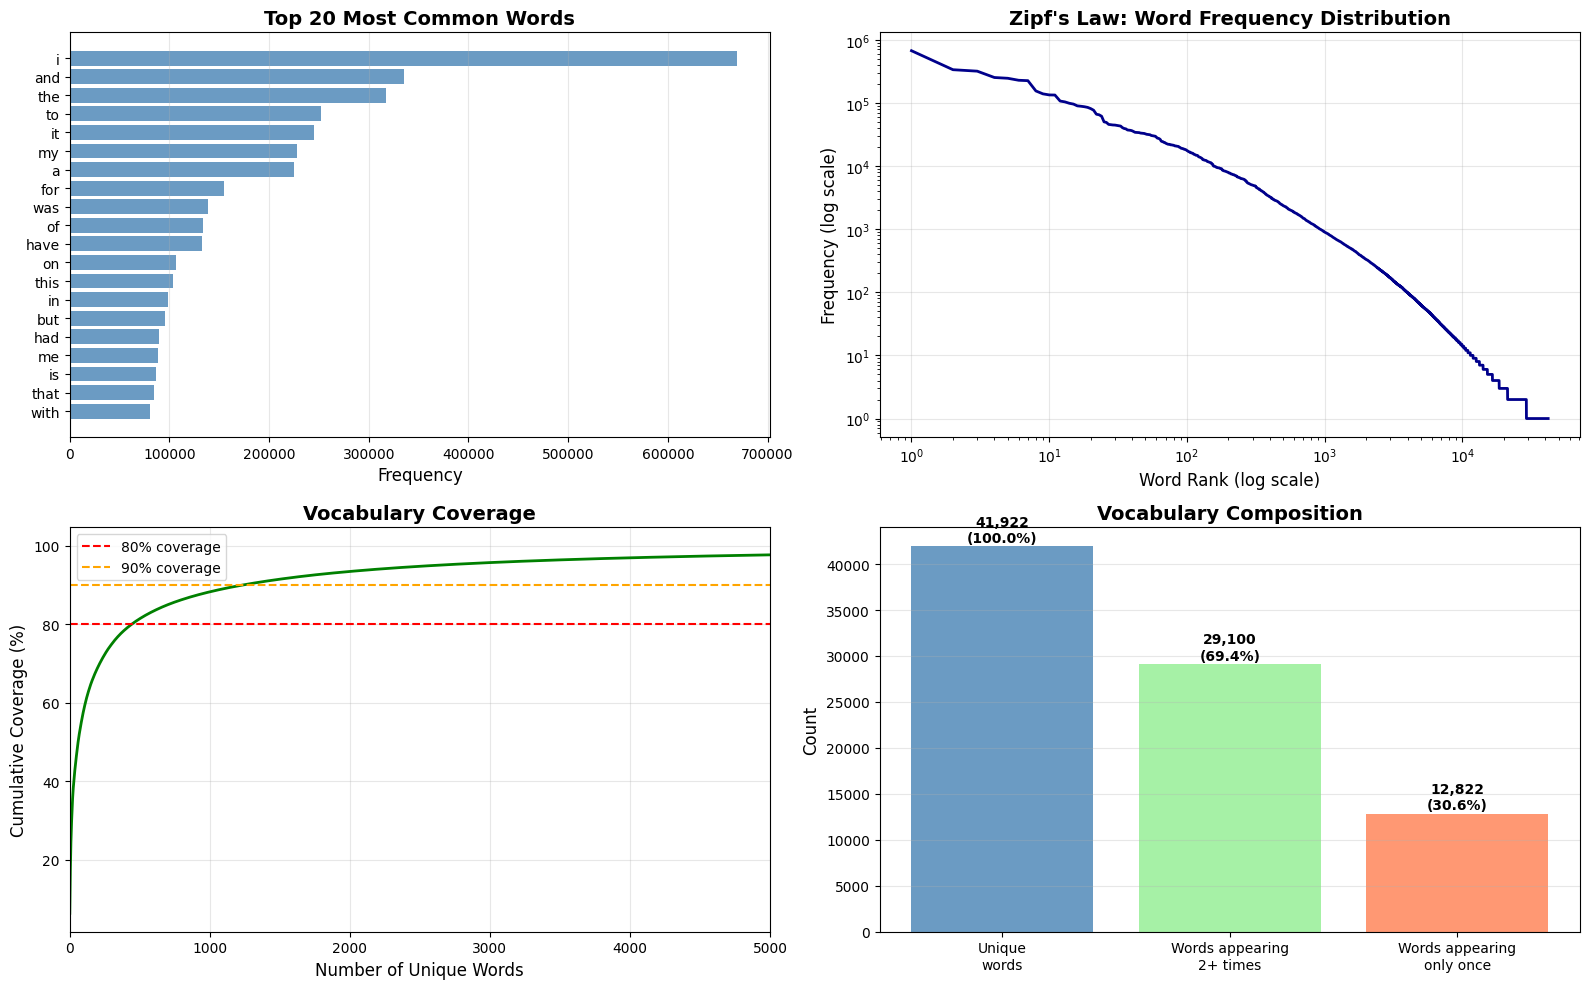


Rare words (appearing only once): 12,822 (30.59%)


In [8]:
# 4. Vocabulary Analysis
from collections import Counter
import re

# Extract all words
all_words = []
for text in train_df[TEXT_COLUMN].fillna(''):
    # Simple tokenization for vocabulary analysis
    words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    all_words.extend(words)

# Count word frequencies
word_freq = Counter(all_words)
most_common = word_freq.most_common(30)

print(f"Total words (with repetition): {len(all_words):,}")
print(f"Unique words (vocabulary size): {len(word_freq):,}")
print(f"Average word frequency: {len(all_words)/len(word_freq):.2f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top 20 most common words
words, counts = zip(*most_common[:20])
axes[0, 0].barh(range(len(words)), counts, color='steelblue', alpha=0.8)
axes[0, 0].set_yticks(range(len(words)))
axes[0, 0].set_yticklabels(words)
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlabel('Frequency', fontsize=12)
axes[0, 0].set_title('Top 20 Most Common Words', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='x')

# Word frequency distribution (log scale)
frequencies = sorted(word_freq.values(), reverse=True)
axes[0, 1].plot(range(1, len(frequencies) + 1), frequencies, color='darkblue', linewidth=2)
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlabel('Word Rank (log scale)', fontsize=12)
axes[0, 1].set_ylabel('Frequency (log scale)', fontsize=12)
axes[0, 1].set_title('Zipf\'s Law: Word Frequency Distribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Vocabulary coverage
cumsum = np.cumsum([count for _, count in word_freq.most_common()])
total_words = sum(word_freq.values())
coverage_pct = (cumsum / total_words) * 100

axes[1, 0].plot(range(1, len(coverage_pct) + 1), coverage_pct, color='green', linewidth=2)
axes[1, 0].axhline(y=80, color='red', linestyle='--', label='80% coverage')
axes[1, 0].axhline(y=90, color='orange', linestyle='--', label='90% coverage')
axes[1, 0].set_xlabel('Number of Unique Words', fontsize=12)
axes[1, 0].set_ylabel('Cumulative Coverage (%)', fontsize=12)
axes[1, 0].set_title('Vocabulary Coverage', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xlim(0, 5000)  # Focus on first 5000 words

# Find words needed for coverage
words_for_80 = np.argmax(coverage_pct >= 80) + 1
words_for_90 = np.argmax(coverage_pct >= 90) + 1
print(f"\nWords needed for 80% coverage: {words_for_80:,}")
print(f"Words needed for 90% coverage: {words_for_90:,}")

# Rare words analysis
rare_words = [word for word, count in word_freq.items() if count == 1]
axes[1, 1].bar(['Unique\nwords', 'Words appearing\n2+ times', 'Words appearing\nonly once'],
               [len(word_freq), len(word_freq) - len(rare_words), len(rare_words)],
               color=['steelblue', 'lightgreen', 'coral'], alpha=0.8)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].set_title('Vocabulary Composition', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')

# Add percentage labels
total = len(word_freq)
for i, v in enumerate([len(word_freq), len(word_freq) - len(rare_words), len(rare_words)]):
    axes[1, 1].text(i, v + 500, f'{v:,}\n({v/total*100:.1f}%)',
                    ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nRare words (appearing only once): {len(rare_words):,} ({len(rare_words)/len(word_freq)*100:.2f}%)")

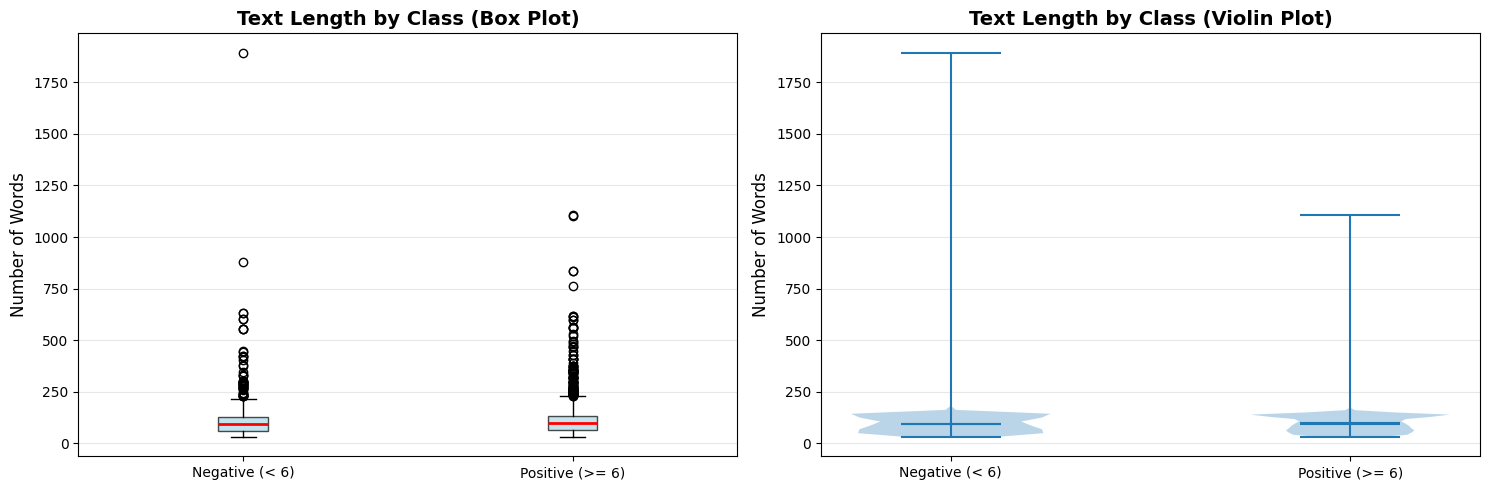

Average text length by class:
                   mean  median        std
binary_class                              
0             93.414061    92.0  39.514043
1             96.342705    97.0  38.440967


In [10]:
# Create text length column
train_df['text_length'] = train_df[TEXT_COLUMN].astype(str).apply(lambda x: len(x.split()))

# Binary class
train_df['binary_class'] = (train_df[LABEL_COLUMN] >= 6).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot
class_labels = ['Negative (< 6)', 'Positive (>= 6)']
data_to_plot = [
    train_df[train_df['binary_class'] == 0]['text_length'],
    train_df[train_df['binary_class'] == 1]['text_length']
]

bp = axes[0].boxplot(
    data_to_plot, labels=class_labels, patch_artist=True,
    boxprops=dict(facecolor='lightblue', alpha=0.7),
    medianprops=dict(color='red', linewidth=2)
)
axes[0].set_ylabel('Number of Words', fontsize=12)
axes[0].set_title('Text Length by Class (Box Plot)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Violin plot
parts = axes[1].violinplot(
    data_to_plot, positions=[1, 2],
    showmeans=True, showmedians=True
)
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(class_labels)
axes[1].set_ylabel('Number of Words', fontsize=12)
axes[1].set_title('Text Length by Class (Violin Plot)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Mean comparison
print("Average text length by class:")
print(train_df.groupby('binary_class')['text_length'].agg(['mean', 'median', 'std']))

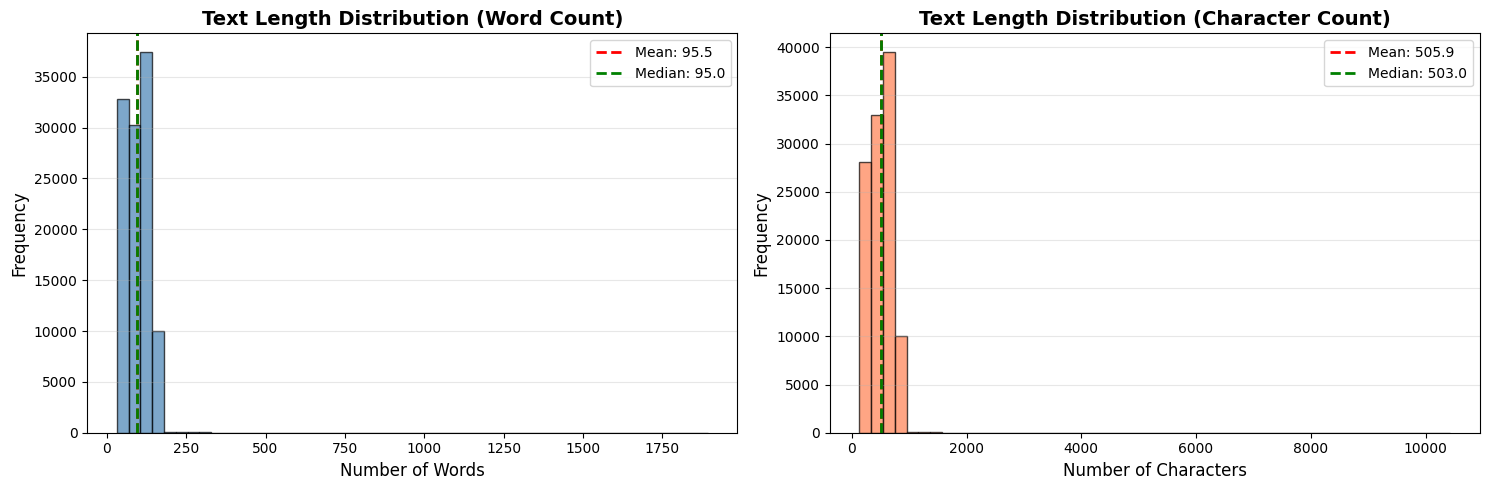

Text Length Statistics:
count    110811.000000
mean         95.475458
std          38.784704
min          31.000000
25%          63.000000
50%          95.000000
75%         130.000000
max        1894.000000
Name: text_length, dtype: float64

90th percentile: 142 words
95th percentile: 147 words
99th percentile: 155 words


In [11]:
# 2. Text Length Distribution
train_df['text_length'] = train_df[TEXT_COLUMN].fillna('').apply(lambda x: len(x.split()))
train_df['char_length'] = train_df[TEXT_COLUMN].fillna('').apply(len)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Word count distribution
axes[0].hist(train_df['text_length'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(train_df['text_length'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {train_df["text_length"].mean():.1f}')
axes[0].axvline(train_df['text_length'].median(), color='green', linestyle='--',
                linewidth=2, label=f'Median: {train_df["text_length"].median():.1f}')
axes[0].set_xlabel('Number of Words', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Text Length Distribution (Word Count)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Character count distribution
axes[1].hist(train_df['char_length'], bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1].axvline(train_df['char_length'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {train_df["char_length"].mean():.1f}')
axes[1].axvline(train_df['char_length'].median(), color='green', linestyle='--',
                linewidth=2, label=f'Median: {train_df["char_length"].median():.1f}')
axes[1].set_xlabel('Number of Characters', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Text Length Distribution (Character Count)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistics
print("Text Length Statistics:")
print(train_df['text_length'].describe())
print(f"\n90th percentile: {train_df['text_length'].quantile(0.9):.0f} words")
print(f"95th percentile: {train_df['text_length'].quantile(0.95):.0f} words")
print(f"99th percentile: {train_df['text_length'].quantile(0.99):.0f} words")

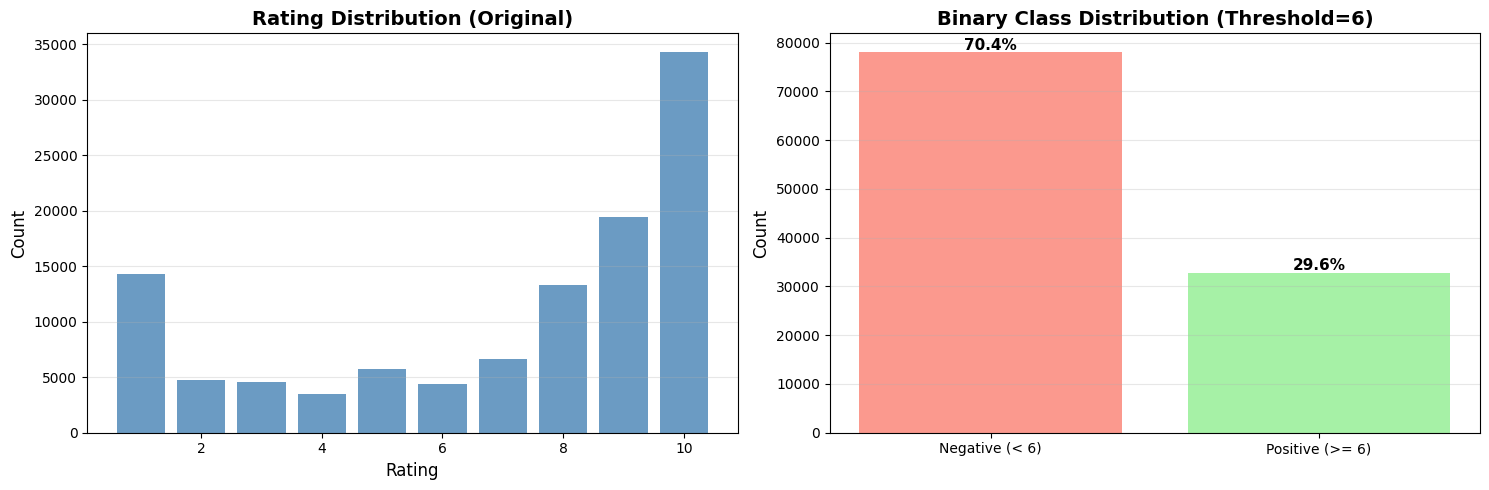

Total samples: 110811
Negative class (< 6): 32814 (29.61%)
Positive class (>= 6): 77997 (70.39%)


In [36]:
# 1. Class Distribution (Rating Distribution)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Raw rating distribution
rating_counts = train_df[LABEL_COLUMN].value_counts().sort_index()
axes[0].bar(rating_counts.index, rating_counts.values, color='steelblue', alpha=0.8)
axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Rating Distribution (Original)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Binary classification distribution (>= 6 vs < 6)
binary_labels = (train_df[LABEL_COLUMN] >= 6).astype(int)
binary_counts = binary_labels.value_counts()
axes[1].bar(['Negative (< 6)', 'Positive (>= 6)'], binary_counts.values,
            color=['salmon', 'lightgreen'], alpha=0.8)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Binary Class Distribution (Threshold=6)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

# Add percentage labels
for i, v in enumerate(binary_counts.values):
    axes[1].text(i, v + 500, f'{v/len(train_df)*100:.1f}%',
                ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Total samples: {len(train_df)}")
print(f"Negative class (< 6): {binary_counts[0]} ({binary_counts[0]/len(train_df)*100:.2f}%)")
print(f"Positive class (>= 6): {binary_counts[1]} ({binary_counts[1]/len(train_df)*100:.2f}%)")

In [12]:
# Download required NLTK data
import nltk
print("Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)  # Open Multilingual WordNet
print(" NLTK data downloaded successfully!")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


 NLTK data downloaded successfully!


In [13]:
# Initialize preprocessor
preprocessor = get_preprocessor(PREPROCESSING_CONFIG)
print(f"Using '{PREPROCESSING_CONFIG}' preprocessing configuration")

# Get tokenized texts (Word2Vec needs tokens, not strings)
print("\nPreprocessing and tokenizing...")
train_texts = train_df[TEXT_COLUMN].fillna('').tolist()
val_texts = val_df[TEXT_COLUMN].fillna('').tolist()
test_texts = test_df[TEXT_COLUMN].fillna('').tolist()

# Get tokenized versions for Word2Vec training
train_tokens = preprocessor.get_tokens_batch(train_texts)
val_tokens = preprocessor.get_tokens_batch(val_texts)
test_tokens = preprocessor.get_tokens_batch(test_texts)

# Extract labels
train_labels = train_df[LABEL_COLUMN].values
val_labels = val_df[LABEL_COLUMN].values
test_labels = test_df[LABEL_COLUMN].values

print(f"✓ Tokenization complete!")
print(f"Example tokenized review: {train_tokens[0][:20]}...")  # First 20 tokens

Using 'minimal' preprocessing configuration

Preprocessing and tokenizing...
✓ Tokenization complete!
Example tokenized review: ['``', 'i', 'have', 'used', 'restasis', 'for', 'about', 'a', 'year', 'now', 'and', 'have', 'seen', 'almost', 'no', 'progress', '.', 'for', 'most', 'of']...


## 4. Train Word2Vec Embeddings

In [14]:
# Initialize and train Word2Vec
print("Training Word2Vec Skip-gram embeddings...")
w2v_model = get_word2vec_embedding(EMBEDDING_CONFIG)
w2v_model.fit(train_tokens)

print("\n✓ Word2Vec training complete!")
print(f"Model info: {w2v_model.get_model_info()}")
print(f"Vocabulary size: {w2v_model.get_vocabulary_size()}")
print(f"Embedding dimension: {w2v_model.embedding_dim}")

Training Word2Vec Skip-gram embeddings...

✓ Word2Vec training complete!
Model info: {'type': 'Skip-gram', 'embedding_dim': 200, 'vocab_size': 41579, 'window_size': 8, 'epochs': 10}
Vocabulary size: 41579
Embedding dimension: 200


In [15]:
# Test Word2Vec embeddings with sample words
print("\nTesting Word2Vec embeddings...")
test_words = ['pain', 'drug', 'effective', 'side', 'effect']

for word in test_words:
    try:
        similar = w2v_model.most_similar(word, topn=5)
        print(f"\n'{word}' most similar:")
        for sim_word, score in similar:
            print(f"  {sim_word}: {score:.3f}")
    except KeyError:
        print(f"\n'{word}' not in vocabulary")


Testing Word2Vec embeddings...

'pain' most similar:
  pain/three: 0.610
  excrutiating: 0.607
  in.all: 0.606
  neck/shoulder/back: 0.605
  pain.: 0.605

'drug' most similar:
  medication: 0.800
  medicine: 0.795
  med: 0.719
  med.: 0.598
  fast-tracked: 0.583

'effective' most similar:
  efficient: 0.631
  useful: 0.615
  helpful: 0.601
  pregnancy.: 0.582
  broad-spectrum: 0.567

'side' most similar:
  side-effects: 0.631
  unreported: 0.619
  blatant: 0.618
  out-weighed: 0.606
  abnominal: 0.604

'effect' most similar:
  effects: 0.715
  affects: 0.671
  affect: 0.637
  unreported: 0.633
  side-effect: 0.605


## 5. Create Sequences and Embedding Matrix

In [16]:
# Build vocabulary from Word2Vec
vocab = w2v_model.get_vocab()
word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab[:VOCAB_SIZE-1])}  # Reserve 0 for padding
word_to_idx['<PAD>'] = 0
word_to_idx['<UNK>'] = len(word_to_idx)

print(f"Vocabulary size (with special tokens): {len(word_to_idx)}")

# Convert tokens to sequences
def tokens_to_sequences(token_lists, word_to_idx):
    sequences = []
    for tokens in token_lists:
        seq = [word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens]
        sequences.append(seq)
    return sequences

train_sequences = tokens_to_sequences(train_tokens, word_to_idx)
val_sequences = tokens_to_sequences(val_tokens, word_to_idx)
test_sequences = tokens_to_sequences(test_tokens, word_to_idx)

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"\nSequence shapes:")
print(f"Train: {train_padded.shape}")
print(f"Val: {val_padded.shape}")
print(f"Test: {test_padded.shape}")

Vocabulary size (with special tokens): 5001

Sequence shapes:
Train: (110811, 75)
Val: (27703, 75)
Test: (46108, 75)


In [17]:
# Create embedding matrix from Word2Vec
print("\nCreating embedding matrix...")
embedding_matrix = np.zeros((len(word_to_idx), EMBEDDING_DIM))

for word, idx in word_to_idx.items():
    if word not in ['<PAD>', '<UNK>']:
        try:
            embedding_matrix[idx] = w2v_model.get_word_vector(word)
        except KeyError:
            # Initialize with small random values
            embedding_matrix[idx] = np.random.randn(EMBEDDING_DIM) * 0.01

print(f"✓ Embedding matrix shape: {embedding_matrix.shape}")
print(f"Non-zero rows: {np.count_nonzero(embedding_matrix.any(axis=1))}")


Creating embedding matrix...
✓ Embedding matrix shape: (5001, 200)
Non-zero rows: 4999


## 6. Process Labels for Classification

In [18]:
# Check the rating distribution to decide on classification strategy
print("Rating distribution:")
print(train_df[LABEL_COLUMN].value_counts().sort_index())

# Convert ratings to classes (adjust based on your dataset)
# Option 1: Binary classification (positive vs negative)
# Option 2: Multi-class classification (ratings 1-10)
# Option 3: Regression (predict exact rating)

# For this example, let's use binary classification: ratings >= 6 = positive (1), < 6 = negative (0)
CLASSIFICATION_TYPE = 'binary'  # 'binary', 'multiclass', or 'regression'
THRESHOLD = 6  # For binary classification

if CLASSIFICATION_TYPE == 'binary':
    train_y = (train_labels >= THRESHOLD).astype(int)
    val_y = (val_labels >= THRESHOLD).astype(int)
    test_y = (test_labels >= THRESHOLD).astype(int)
    NUM_CLASSES = 2
    print(f"\nBinary classification: >= {THRESHOLD} = positive")
    print(f"Train class distribution: {np.bincount(train_y)}")
elif CLASSIFICATION_TYPE == 'multiclass':
    train_y = train_labels.astype(int) - 1  # Assuming ratings 1-10, convert to 0-9
    val_y = val_labels.astype(int) - 1
    test_y = test_labels.astype(int) - 1
    NUM_CLASSES = len(np.unique(train_y))
    print(f"\nMulti-class classification: {NUM_CLASSES} classes")
else:  # regression
    train_y = train_labels.astype(float)
    val_y = val_labels.astype(float)
    test_y = test_labels.astype(float)
    NUM_CLASSES = 1
    print("\nRegression: Predicting exact rating")

Rating distribution:
rating
1.0     14286
2.0      4776
3.0      4540
4.0      3501
5.0      5711
6.0      4359
7.0      6671
8.0     13305
9.0     19407
10.0    34255
Name: count, dtype: int64

Binary classification: >= 6 = positive
Train class distribution: [32814 77997]


## 7. Build LSTM Model

In [19]:
def build_lstm_model(
    vocab_size,
    embedding_dim,
    embedding_matrix,
    max_length,
    lstm_units=128,
    dropout_rate=0.3,
    recurrent_dropout=0.2,
    dense_units=64,
    num_classes=2,
    use_bidirectional=True,
    classification_type='binary'
):
    """
    Build LSTM or BiLSTM model for text classification.

    Args:
        vocab_size: Size of vocabulary
        embedding_dim: Dimension of embeddings
        embedding_matrix: Pre-trained embedding matrix
        max_length: Maximum sequence length
        lstm_units: Number of LSTM units
        dropout_rate: Dropout rate
        recurrent_dropout: Recurrent dropout rate
        dense_units: Dense layer units
        num_classes: Number of output classes
        use_bidirectional: Use BiLSTM if True
        classification_type: 'binary', 'multiclass', or 'regression'

    Returns:
        Compiled Keras model
    """
    model = Sequential()

    # Embedding layer with pre-trained Word2Vec weights
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False,  # Freeze Word2Vec embeddings (can set to True for fine-tuning)
        name='embedding'
    ))

    # LSTM layer(s)
    if use_bidirectional:
        model.add(Bidirectional(
            LSTM(
                lstm_units,
                return_sequences=True,
                dropout=dropout_rate,
                recurrent_dropout=recurrent_dropout
            ),
            name='bilstm_1'
        ))
        # Second BiLSTM layer
        model.add(Bidirectional(
            LSTM(
                lstm_units // 2,
                dropout=dropout_rate,
                recurrent_dropout=recurrent_dropout
            ),
            name='bilstm_2'
        ))
    else:
        model.add(LSTM(
            lstm_units,
            return_sequences=True,
            dropout=dropout_rate,
            recurrent_dropout=recurrent_dropout,
            name='lstm_1'
        ))
        model.add(LSTM(
            lstm_units // 2,
            dropout=dropout_rate,
            recurrent_dropout=recurrent_dropout,
            name='lstm_2'
        ))

    # Dense layers
    model.add(Dense(dense_units, activation='relu', name='dense_1'))
    model.add(Dropout(dropout_rate))

    # Output layer
    if classification_type == 'binary':
        model.add(Dense(1, activation='sigmoid', name='output'))
        loss = 'binary_crossentropy'
        metrics = ['accuracy']
    elif classification_type == 'multiclass':
        model.add(Dense(num_classes, activation='softmax', name='output'))
        loss = 'sparse_categorical_crossentropy'
        metrics = ['accuracy']
    else:  # regression
        model.add(Dense(1, activation='linear', name='output'))
        loss = 'mse'
        metrics = ['mae']

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss=loss,
        metrics=metrics
    )

    return model

# Build the model
print("Building LSTM model...")
model = build_lstm_model(
    vocab_size=len(word_to_idx),
    embedding_dim=EMBEDDING_DIM,
    embedding_matrix=embedding_matrix,
    max_length=MAX_SEQUENCE_LENGTH,
    lstm_units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE,
    recurrent_dropout=RECURRENT_DROPOUT,
    dense_units=DENSE_UNITS,
    num_classes=NUM_CLASSES,
    use_bidirectional=USE_BIDIRECTIONAL,
    classification_type=CLASSIFICATION_TYPE
)

print("\n✓ Model built successfully!")
model.summary()

Building LSTM model...

✓ Model built successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,200 (3.82 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,200 (3.82 MB)

## 8. Setup Callbacks

In [20]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_lstm_word2vec_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured:")
print("- Early stopping (patience=3)")
print("- Learning rate reduction")
print("- Model checkpointing")

Callbacks configured:
- Early stopping (patience=3)
- Learning rate reduction
- Model checkpointing


## 9. Train the Model

In [21]:
# Train the model
print("\nStarting training...")
print(f"Model: {'BiLSTM' if USE_BIDIRECTIONAL else 'LSTM'}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")
print("="*50)

history = model.fit(
    train_padded,
    train_y,
    validation_data=(val_padded, val_y),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training complete!")


Starting training...
Model: LSTM
Batch size: 256
Max epochs: 15
Epoch 1/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7032 - loss: 0.6056
Epoch 1: val_loss improved from inf to 0.50807, saving model to best_lstm_word2vec_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 148s 321ms/step - accuracy: 0.7032 - loss: 0.6055 - val_accuracy: 0.7605 - val_loss: 0.5081 - learning_rate: 0.0010
Epoch 2/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7357 - loss: 0.5411
Epoch 2: val_loss improved from 0.50807 to 0.47751, saving model to best_lstm_word2vec_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 136s 315ms/step - accuracy: 0.7357 - loss: 0.5411 - val_accuracy: 0.7777 - val_loss: 0.4775 - learning_rate: 0.0010
Epoch 3/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7588 - loss: 0.5075
Epoch 3: val_loss improved from 0.47751 to 0.45162, saving model to best_lstm_word2vec_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 136s 314ms/step - accuracy: 0.7588 - loss: 0.5075 - val_accuracy: 0.7928 - val_loss: 0.4516 - learning_rate: 0.0010
Epoch 4/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7782 - loss: 0.4772
Epoch 4: val_loss improved from 0.45162 to 0.43182, saving model to best_lstm_word2vec_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 136s 315ms/step - accuracy: 0.7782 - loss: 0.4772 - val_accuracy: 0.8032 - val_loss: 0.4318 - learning_rate: 0.0010
Epoch 5/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7869 - loss: 0.4603
Epoch 5: val_loss improved from 0.43182 to 0.42299, saving model to best_lstm_word2vec_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 136s 314ms/step - accuracy: 0.7869 - loss: 0.4602 - val_accuracy: 0.8063 - val_loss: 0.4230 - learning_rate: 0.0010
Epoch 6/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7952 - loss: 0.4449
Epoch 6: val_loss improved from 0.42299 to 0.40955, saving model to best_lstm_word2vec_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 136s 315ms/step - accuracy: 0.7952 - loss: 0.4449 - val_accuracy: 0.8140 - val_loss: 0.4096 - learning_rate: 0.0010
Epoch 7/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8004 - loss: 0.4353
Epoch 7: val_loss improved from 0.40955 to 0.40075, saving model to best_lstm_word2vec_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 136s 314ms/step - accuracy: 0.8004 - loss: 0.4353 - val_accuracy: 0.8225 - val_loss: 0.4007 - learning_rate: 0.0010
Epoch 8/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8052 - loss: 0.4293
Epoch 8: val_loss improved from 0.40075 to 0.39773, saving model to best_lstm_word2vec_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 136s 314ms/step - accuracy: 0.8053 - loss: 0.4293 - val_accuracy: 0.8205 - val_loss: 0.3977 - learning_rate: 0.0010
Epoch 9/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8076 - loss: 0.4220
Epoch 9: val_loss did not improve from 0.39773
433/433 ━━━━━━━━━━━━━━━━━━━━ 135s 313ms/step - accuracy: 0.8076 - loss: 0.4220 - val_accuracy: 0.8158 - val_loss: 0.4016 - learning_rate: 0.0010
Epoch 10/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8131 - loss: 0.4131
Epoch 10: val_loss improved from 0.39773 to 0.38457, saving model to best_lstm_word2vec_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 136s 314ms/step - accuracy: 0.8131 - loss: 0.4131 - val_accuracy: 0.8284 - val_loss: 0.3846 - learning_rate: 0.0010
Epoch 11/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8161 - loss: 0.4090
Epoch 11: val_loss improved from 0.38457 to 0.38065, saving model to best_lstm_word2vec_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 138s 320ms/step - accuracy: 0.8161 - loss: 0.4090 - val_accuracy: 0.8311 - val_loss: 0.3807 - learning_rate: 0.0010
Epoch 12/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8177 - loss: 0.4065
Epoch 12: val_loss did not improve from 0.38065
433/433 ━━━━━━━━━━━━━━━━━━━━ 139s 314ms/step - accuracy: 0.8177 - loss: 0.4065 - val_accuracy: 0.8305 - val_loss: 0.3820 - learning_rate: 0.0010
Epoch 13/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8201 - loss: 0.4000
Epoch 13: val_loss improved from 0.38065 to 0.37414, saving model to best_lstm_word2vec_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 136s 315ms/step - accuracy: 0.8201 - loss: 0.4000 - val_accuracy: 0.8340 - val_loss: 0.3741 - learning_rate: 0.0010
Epoch 14/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8196 - loss: 0.3983
Epoch 14: val_loss improved from 0.37414 to 0.36910, saving model to best_lstm_word2vec_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 136s 314ms/step - accuracy: 0.8196 - loss: 0.3983 - val_accuracy: 0.8372 - val_loss: 0.3691 - learning_rate: 0.0010
Epoch 15/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8298 - loss: 0.3857
Epoch 15: val_loss improved from 0.36910 to 0.36796, saving model to best_lstm_word2vec_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 136s 314ms/step - accuracy: 0.8298 - loss: 0.3857 - val_accuracy: 0.8358 - val_loss: 0.3680 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 15.

✓ Training complete!


## 10. Plot Training History

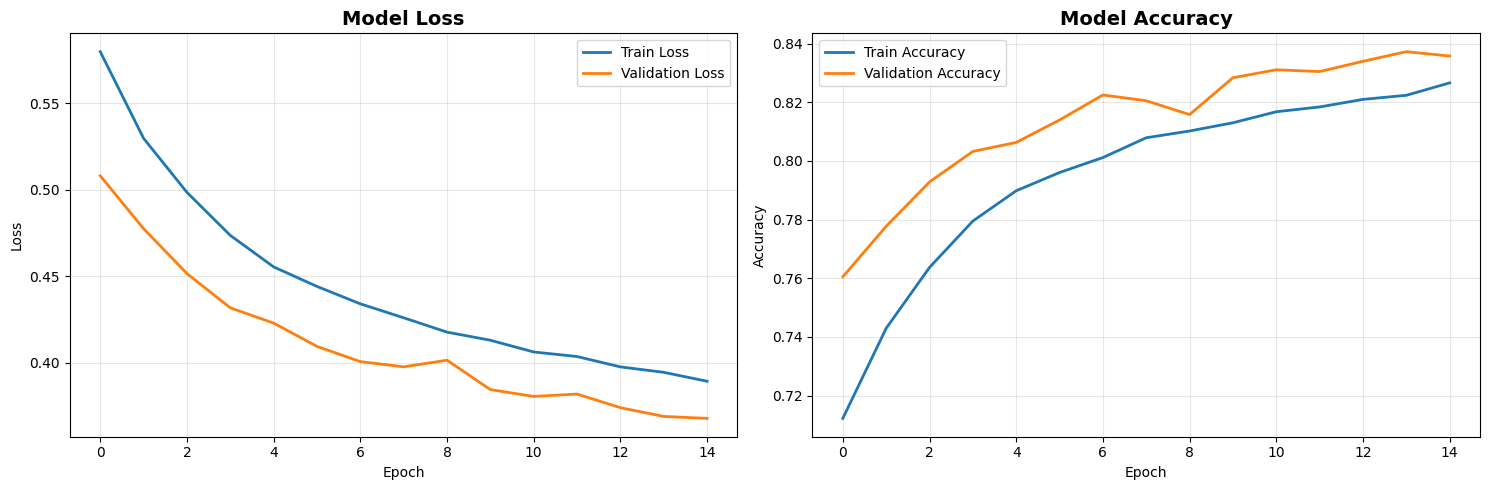

In [22]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy plot (for classification)
if CLASSIFICATION_TYPE in ['binary', 'multiclass']:
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
else:  # regression
    axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1].set_title('Model MAE', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Evaluate on Test Set

In [23]:
# Evaluate on test set
print("Evaluating on test set...")
test_results = model.evaluate(test_padded, test_y, verbose=1)

if CLASSIFICATION_TYPE in ['binary', 'multiclass']:
    print(f"\nTest Loss: {test_results[0]:.4f}")
    print(f"Test Accuracy: {test_results[1]:.4f}")
else:
    print(f"\nTest Loss (MSE): {test_results[0]:.4f}")
    print(f"Test MAE: {test_results[1]:.4f}")

Evaluating on test set...
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.8328 - loss: 0.3739

Test Loss: 0.3717
Test Accuracy: 0.8333


In [24]:
# Get predictions
print("\nGenerating predictions...")
test_predictions = model.predict(test_padded, verbose=1)

if CLASSIFICATION_TYPE == 'binary':
    test_pred_classes = (test_predictions > 0.5).astype(int).flatten()
elif CLASSIFICATION_TYPE == 'multiclass':
    test_pred_classes = np.argmax(test_predictions, axis=1)
else:  # regression
    test_pred_classes = test_predictions.flatten()

print(" Predictions generated")


Generating predictions...
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 46s 32ms/step
 Predictions generated


## 12. Detailed Classification Report


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.7923    0.6026    0.6845     13839
           1     0.8454    0.9323    0.8867     32269

    accuracy                         0.8333     46108
   macro avg     0.8189    0.7674    0.7856     46108
weighted avg     0.8295    0.8333    0.8260     46108



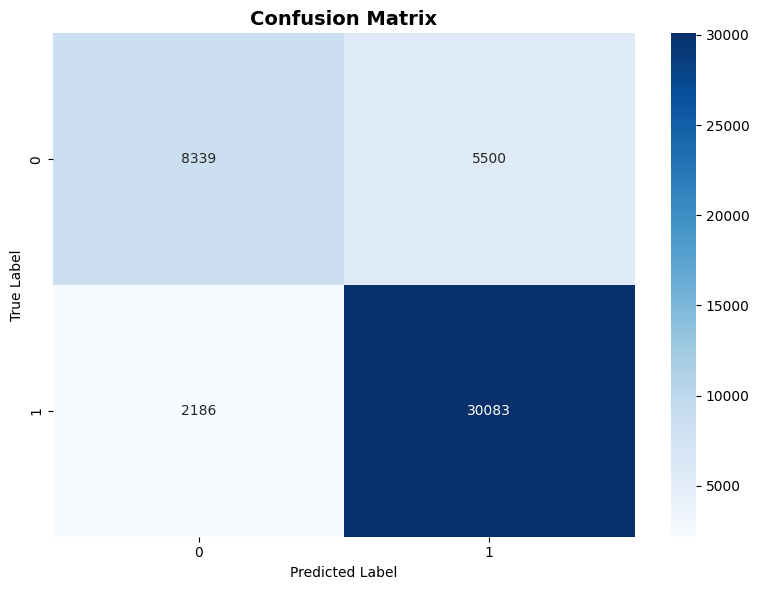


Per-Class Metrics:
   Precision    Recall  F1-Score  Support
0   0.792304  0.602572  0.684535    13839
1   0.845432  0.932257  0.886724    32269


In [25]:
if CLASSIFICATION_TYPE in ['binary', 'multiclass']:
    # Classification report
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(test_y, test_pred_classes, digits=4))

    # Confusion matrix
    cm = confusion_matrix(test_y, test_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(test_y, test_pred_classes)

    metrics_df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

    print("\nPer-Class Metrics:")
    print(metrics_df.to_string())
else:
    # Regression metrics
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    mse = mean_squared_error(test_y, test_pred_classes)
    mae = mean_absolute_error(test_y, test_pred_classes)
    r2 = r2_score(test_y, test_pred_classes)

    print("\n" + "="*50)
    print("REGRESSION METRICS")
    print("="*50)
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(test_y, test_pred_classes, alpha=0.5)
    plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--', lw=2)
    plt.xlabel('True Rating')
    plt.ylabel('Predicted Rating')
    plt.title('Predicted vs True Ratings')
    plt.tight_layout()
    plt.show()

## 13. Save Results

In [26]:
# Compile results dictionary
results = {
    'model': 'BiLSTM' if USE_BIDIRECTIONAL else 'LSTM',
    'embedding': f'{EMBEDDING_TYPE}_{EMBEDDING_CONFIG}',
    'embedding_dim': EMBEDDING_DIM,
    'lstm_units': LSTM_UNITS,
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'vocab_size': len(word_to_idx),
    'preprocessing': PREPROCESSING_CONFIG,
    'batch_size': BATCH_SIZE,
    'epochs_trained': len(history.history['loss']),
    'classification_type': CLASSIFICATION_TYPE,
}

if CLASSIFICATION_TYPE in ['binary', 'multiclass']:
    results['test_accuracy'] = float(test_results[1])
    results['test_loss'] = float(test_results[0])

    # Add precision, recall, f1
    precision, recall, f1, _ = precision_recall_fscore_support(test_y, test_pred_classes, average='weighted')
    results['precision'] = float(precision)
    results['recall'] = float(recall)
    results['f1_score'] = float(f1)
else:
    results['test_mse'] = float(test_results[0])
    results['test_mae'] = float(test_results[1])
    results['r2_score'] = float(r2_score(test_y, test_pred_classes))

print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
for key, value in results.items():
    print(f"{key}: {value}")

# Save results to JSON
import json
with open('/content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings/notebooks/lstm_word2vec_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n Results saved to 'lstm_word2vec_results.json'")


FINAL RESULTS SUMMARY
model: LSTM
embedding: word2vec_skipgram_medium
embedding_dim: 200
lstm_units: 32
max_sequence_length: 75
vocab_size: 5001
preprocessing: minimal
batch_size: 256
epochs_trained: 15
classification_type: binary
test_accuracy: 0.8333044052124023
test_loss: 0.3717281222343445
precision: 0.8294858717028917
recall: 0.8333044157196148
f1_score: 0.8260382584279587

 Results saved to 'lstm_word2vec_results.json'


## 14. Model Summary and Next Steps

In [28]:
print("\n" + "="*70)
print("LSTM + WORD2VEC SKIP-GRAM - EXPERIMENT COMPLETE")
print("="*70)
print(f"\nModel: {'BiLSTM' if USE_BIDIRECTIONAL else 'LSTM'}")
print(f"Embedding: Word2Vec Skip-gram (200-dim)")
print(f"Total Parameters: {model.count_params():,}")

if CLASSIFICATION_TYPE in ['binary', 'multiclass']:
    print(f"\nFinal Test Accuracy: {results['test_accuracy']:.4f}")
    print(f"F1-Score: {results['f1_score']:.4f}")
else:
    print(f"\nFinal Test MAE: {results['test_mae']:.4f}")
    print(f"R² Score: {results['r2_score']:.4f}")



LSTM + WORD2VEC SKIP-GRAM - EXPERIMENT COMPLETE

Model: LSTM
Embedding: Word2Vec Skip-gram (200-dim)
Total Parameters: 1,034,313

Final Test Accuracy: 0.8333
F1-Score: 0.8260
